In [1]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [2]:
!pip install seaborn



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from KE.classifier.prepare import split_dataset
from KE.dataclean import tables

In [4]:
import random
import numpy as np
import os
#import tensorflow as tf
#import torch

SEED_VALUE = 62

# Seed for Python's built-in random module
random.seed(SEED_VALUE)

# Seed for NumPy
np.random.seed(SEED_VALUE)

# Seed for TensorFlow
#tf.random.set_seed(SEED_VALUE)

# Seed for PyTorch
#torch.manual_seed(your_seed_value)
#torch.cuda.manual_seed_all(SEED_VALUE)

# Environment-level seed (less common)
#os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

In [5]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_62464/2785372968.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")


In [6]:
data

,id,subject,predicate,object,relation,provided_by,knowledge_source,meta,primary_knowledge_source
0,urn:uuid:73cba8fe-fd35-4eba-93db-0019ed1a8b06,NCBITaxon:1,biolink:subclass_of,BFO:0000040,rdfs:subClassOf,NaN,Graph,NaN,NaN
1,urn:uuid:580dad0e-72e9-4957-98a0-8bcba6c307ec,NCBITaxon:10,biolink:subclass_of,NCBITaxon:1706371,rdfs:subClassOf,NaN,Graph,NaN,NaN
2,urn:uuid:12b7955c-3df5-413d-a428-69329bed9ada,NCBITaxon:100,biolink:subclass_of,NCBITaxon:99,rdfs:subClassOf,NaN,Graph,NaN,NaN
3,urn:uuid:98a806db-c546-4005-a970-2e8819970e3f,NCBITaxon:100,biolink:occurs_in,mediadive.medium:7,BAO:0002924|BAO:0002924,NaN,Graph,NaN,"['bacdive:17385', 'bacdive:17391']"
4,urn:uuid:71aa618f-652b-4798-9a0f-2c2dc45c7374,NCBITaxon:100,biolink:occurs_in,mediadive.medium:428,BAO:0002924,NaN,Graph,NaN,bacdive:17384
...,...,...,...,...,...,...,...,...,...
1495724,urn:uuid:889b1bfb-7b2e-4c1c-a159-241878d3ece4,NCBITaxon:147448,biolink:has_phenotype,traits.cell_shape_enum:coccus,RO:0002200,NaN,Graph,NaN,NaN
1495725,urn:uuid:81001752-4b36-46a9-a5d7-26c26112e6c2,NCBITaxon:147448,biolink:capable_of,ECOCORE:00000177,RO:0002215,NaN,Graph,NaN,NaN
1495726,urn:uuid:16e5e180-16ac-463c-8001-52a1f761a069,NCBITaxon:1240726,biolink:has_phenotype,traits.cell_shape_enum:bacillus,RO:0002200,NaN,Graph,NaN,NaN
1495727,urn:uuid:7ed27a78-f138-4ce9-9aaf-dc76c929ca95,NCBITaxon:1240783,biolink:has_phenotype,traits.cell_shape_enum:bacillus,RO:0002200,NaN,Graph,NaN,NaN


In [7]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,mediadive.medium:7
4,NCBITaxon:100,mediadive.medium:428
...,...,...
1495724,NCBITaxon:147448,traits.cell_shape_enum:coccus
1495725,NCBITaxon:147448,ECOCORE:00000177
1495726,NCBITaxon:1240726,traits.cell_shape_enum:bacillus
1495727,NCBITaxon:1240783,traits.cell_shape_enum:bacillus


In [8]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32512, 2)

In [9]:
#add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(38476, 2)

In [10]:
#add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

In [11]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(47187, 2)

In [12]:
data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Step 3: Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_oxidation,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)


In [14]:
data_df['medium'].isna().sum()

20368

In [15]:
data_df = data_df[data_df['medium'].notna()]
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:J346
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:668
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [16]:
#data_pairs_clean = tables.rows_ad_cols_quant_filter(data_pairs)
#require at least 10 examples per class
data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>9)

In [17]:
data_df_clean

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:J346
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J14
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [18]:
# Splitting the data into features and target labels
X = data_df_clean.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_clean['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

train_data = Pool(data=X_train, label=y_train, cat_features=[0])
val_data = Pool(data=X_val, label=y_val, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [50]:
## Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
## Train the model
#train_data = Pool(data=X_train, label=y_train, cat_features=[0])
#test_data = Pool(data=X_test, label=y_test, cat_features=[0])


In [21]:
model = CatBoostClassifier(random_seed=SEED_VALUE,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.1, 
                           depth=4, 
                           l2_leaf_reg=3,
                           bagging_temperature=1,
                           random_strength=5,
                           verbose=100)
model.fit(train_data, eval_set=val_data)#, plot=True)

0:	learn: 4.4299213	test: 4.4301036	best: 4.4301036 (0)	total: 122ms	remaining: 20m 21s
100:	learn: 3.3464633	test: 3.4822193	best: 3.4822193 (100)	total: 5.73s	remaining: 9m 21s
200:	learn: 3.0203991	test: 3.3023576	best: 3.3023576 (200)	total: 11.5s	remaining: 9m 21s
300:	learn: 2.8799289	test: 3.2638842	best: 3.2638842 (300)	total: 17.1s	remaining: 9m 11s
400:	learn: 2.7845186	test: 3.2453531	best: 3.2452921 (397)	total: 22.7s	remaining: 9m 3s
500:	learn: 2.7176061	test: 3.2392567	best: 3.2392567 (500)	total: 28.3s	remaining: 8m 57s
600:	learn: 2.6513529	test: 3.2335369	best: 3.2335369 (600)	total: 33.9s	remaining: 8m 50s
700:	learn: 2.5918421	test: 3.2337988	best: 3.2326560 (644)	total: 39.5s	remaining: 8m 44s
800:	learn: 2.5444294	test: 3.2328931	best: 3.2322192 (785)	total: 45.1s	remaining: 8m 37s
900:	learn: 2.5024175	test: 3.2335908	best: 3.2315690 (856)	total: 50.7s	remaining: 8m 32s
1000:	learn: 2.4625896	test: 3.2331165	best: 3.2315690 (856)	total: 56.3s	remaining: 8m 25s
11

In [51]:
#model = CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=6, verbose=100)
#model.fit(train_data)#, plot=True)

0:	learn: 4.6352234	total: 141ms	remaining: 23m 33s
100:	learn: 3.7585769	total: 12.5s	remaining: 20m 25s
200:	learn: 3.5439635	total: 25s	remaining: 20m 18s
300:	learn: 3.4381166	total: 37.5s	remaining: 20m 6s
400:	learn: 3.3669092	total: 49.6s	remaining: 19m 48s
500:	learn: 3.3124992	total: 1m 1s	remaining: 19m 34s
600:	learn: 3.2630870	total: 1m 14s	remaining: 19m 21s
700:	learn: 3.2182194	total: 1m 26s	remaining: 19m 6s
800:	learn: 3.1764331	total: 1m 38s	remaining: 18m 53s
900:	learn: 3.1329018	total: 1m 51s	remaining: 18m 42s
1000:	learn: 3.0883124	total: 2m 3s	remaining: 18m 30s
1100:	learn: 3.0463546	total: 2m 15s	remaining: 18m 17s
1200:	learn: 3.0071590	total: 2m 28s	remaining: 18m 5s
1300:	learn: 2.9743460	total: 2m 40s	remaining: 17m 52s
1400:	learn: 2.9448925	total: 2m 53s	remaining: 17m 41s
1500:	learn: 2.9180936	total: 3m 5s	remaining: 17m 30s
1600:	learn: 2.8945902	total: 3m 17s	remaining: 17m 18s
1700:	learn: 2.8729906	total: 3m 30s	remaining: 17m 6s
1800:	learn: 2.853

In [23]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.23516642547033284

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.12      0.17      0.14        66
  mediadive.medium:104       0.00      0.00      0.00        18
 mediadive.medium:104b       0.50      0.17      0.25         6
 mediadive.medium:104c       0.00      0.00      0.00         3
mediadive.medium:1076b       0.00      0.00      0.00         9
   mediadive.medium:11       0.36      0.33      0.34        30
  mediadive.medium:110       0.00      0.00      0.00        10
  mediadive.medium:119       0.75      1.00      0.86         3
 mediadive.medium:1203       0.00      0.00      0.00         2
mediadive.medium:1203a       0.00      0.00      0.00         2
  mediadive.medium:141       1.00      0.33      0.50         3
  mediadive.medium:144       0.00      0.00      0.00         2
 mediadive.medium:1523       0.50      0.33      0.40         3
  mediadive.medium:193       0.00      0.00     

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [24]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.3474903474903475

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.22      0.28      0.25       199
  mediadive.medium:104       0.33      0.02      0.04        54
 mediadive.medium:104b       0.00      0.00      0.00        18
 mediadive.medium:104c       0.00      0.00      0.00         8
mediadive.medium:1076b       0.00      0.00      0.00        28
   mediadive.medium:11       0.48      0.64      0.55        91
  mediadive.medium:110       1.00      0.03      0.06        31
  mediadive.medium:119       0.83      0.50      0.62        10
 mediadive.medium:1203       1.00      0.14      0.25         7
mediadive.medium:1203a       0.00      0.00      0.00         6
  mediadive.medium:141       0.80      0.80      0.80        10
  mediadive.medium:144       1.00      0.17      0.29         6
 mediadive.medium:1523       0.64      0.70      0.67        10
  mediadive.medium:193       1.00      0.17      

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [25]:
len(y_test.unique())

106

In [26]:
from sklearn.metrics import confusion_matrix

# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

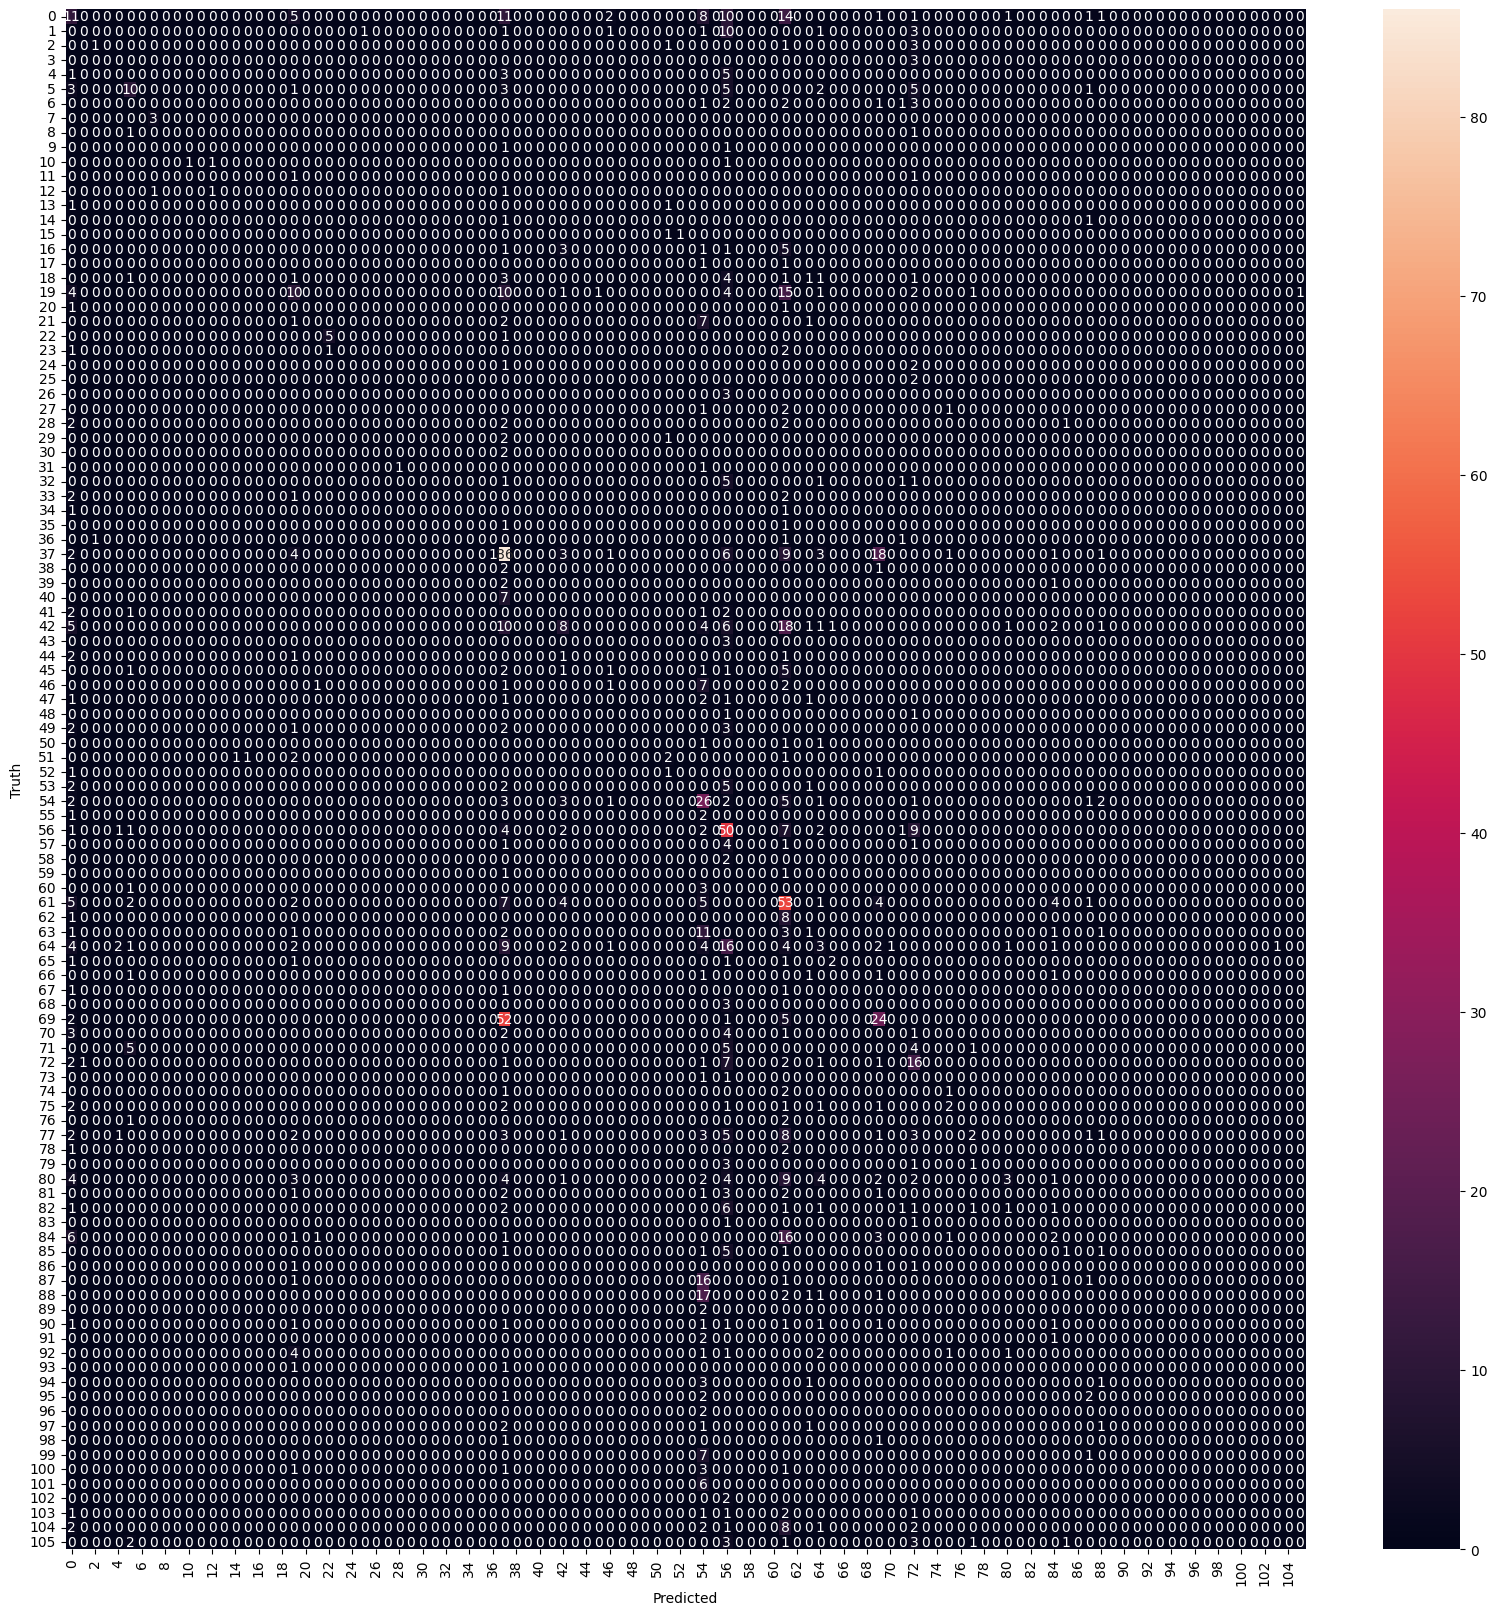

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('20231201_test_confusion_matrix.pdf', format='pdf')
plt.show()